In [64]:
import torch
import torch_geometric
from torch_geometric import utils
from torch_geometric.nn import SAGEConv
import torch.nn as nn
import torch.nn.functional as F

from scipy.sparse import coo_matrix
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [65]:
ec_hic = np.load('data/ec_adj_mat_t25.npy')
hsr_hic = np.load('data/hsr_adj_mat_t25.npy')

ec_df = pd.read_csv('data/ec_cleaned.csv')
hsr_df = pd.read_csv('data/hsr_cleaned.csv')

hsr_feats = torch.tensor(hsr_df[['read_count', 'total_genes']].to_numpy())
hsr_labels = torch.zeros(hsr_feats.shape[0])

ec_feats = torch.tensor(ec_df[['read_count', 'total_genes']].to_numpy())
ec_labels = torch.ones(ec_feats.shape[0])

def hic_to_sparse(hic_mat):
    adj_mat = np.triu(hic_mat)
    sparse_adj = coo_matrix(adj_mat)

    return utils.from_scipy_sparse_matrix(sparse_adj)

hsr_edge_index, hsr_edge_attr = hic_to_sparse(hsr_hic)
hsr_graph = torch_geometric.data.Data(edge_index = hsr_edge_index, edge_attr = hsr_edge_attr, x = hsr_feats, y = hsr_labels)

ec_edge_index, ec_edge_attr = hic_to_sparse(ec_hic)
ec_graph = torch_geometric.data.Data(edge_index = ec_edge_index, edge_attr = ec_edge_attr, x = ec_feats, y = ec_labels)

x = torch.cat([ec_feats, hsr_feats], dim=0)
hsr_edge_index = hsr_edge_index + ec_labels.shape[0]
edge_index = torch.cat([ec_edge_index, hsr_edge_index], dim=1)
edge_attr = torch.cat([ec_edge_attr, hsr_edge_attr], dim=0)
labels = torch.cat([ec_labels, hsr_labels], dim=0)

G = torch_geometric.data.Data(edge_index = edge_index, edge_attr = edge_attr, x = x, y = labels)

In [66]:
class GraphSAGE(nn.Module):
    def __init__(self, num_feat, num_graph_conv_layers, graph_conv_layer_sizes, num_lin_layers, lin_hidden_sizes, num_classes):
        super().__init__()
        self.num_graph_conv_layers = num_graph_conv_layers
        self.num_lin_layers = num_lin_layers
        self.embeddings = None

        if self.num_graph_conv_layers == 1:
            self.conv1 = SAGEConv(graph_conv_layer_sizes[0], graph_conv_layer_sizes[1])
        elif self.num_graph_conv_layers == 2:
            self.conv1 = SAGEConv(graph_conv_layer_sizes[0], graph_conv_layer_sizes[1])
            self.conv2 = SAGEConv(graph_conv_layer_sizes[1], graph_conv_layer_sizes[2])
        elif self.num_graph_conv_layers == 3:
            self.conv1 = SAGEConv(graph_conv_layer_sizes[0], graph_conv_layer_sizes[1])
            self.conv2 = SAGEConv(graph_conv_layer_sizes[1], graph_conv_layer_sizes[2])
            self.conv3 = SAGEConv(graph_conv_layer_sizes[2], graph_conv_layer_sizes[3])
        
        if self.num_lin_layers == 1:
            self.lin1 = nn.Linear(lin_hidden_sizes[0], lin_hidden_sizes[1])
        elif self.num_lin_layers == 2:
            self.lin1 = nn.Linear(lin_hidden_sizes[0], lin_hidden_sizes[1])
            self.lin2 = nn.Linear(lin_hidden_sizes[1], lin_hidden_sizes[2])
        elif self.num_lin_layers == 3:
            self.lin1 = nn.Linear(lin_hidden_sizes[0], lin_hidden_sizes[1])
            self.lin2 = nn.Linear(lin_hidden_sizes[1], lin_hidden_sizes[2])
            self.lin3 = nn.Linear(lin_hidden_sizes[2], lin_hidden_sizes[3])
            
        self.loss_calc = nn.CrossEntropyLoss()
        self.torch_softmax = nn.Softmax(dim=1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        ### Graph convolution module
        if self.num_graph_conv_layers == 1:
            h = self.conv1(x, edge_index)
            h = torch.relu(h)
        elif self.num_graph_conv_layers == 2:
            h = self.conv1(x, edge_index)
            h = torch.relu(h)
            h = self.conv2(h, edge_index)
            h = torch.relu(h)
        elif self.num_graph_conv_layers == 3:
            h = self.conv1(x, edge_index)
            h = torch.relu(h)
            h = self.conv2(h, edge_index)
            h = torch.relu(h)
            h = self.conv3(h, edge_index)
            h = torch.relu(h)
            
        #h = F.dropout(h, p = self.dropout_value)
        self.embeddings = h
        scores = h
        ### Linear module
        if self.num_lin_layers == 0:
            return scores
        elif self.num_lin_layers == 1:
            scores = self.lin1(scores)
        elif self.num_lin_layers == 2:
            scores = self.lin1(scores)
            scores = torch.relu(scores)
            scores = self.lin2(scores)
        elif self.num_lin_layers == 3:
            scores = self.lin1(scores)
            scores = torch.relu(scores)
            scores = self.lin2(scores)
            scores = torch.relu(scores)
            scores = self.lin3(scores)
        
        return scores

    def loss(self, scores, labels):
        xent_loss = self.loss_calc(scores, labels)
        return xent_loss
    
    def calc_softmax_pred(self, scores):
        softmax = self.torch_softmax(scores)
        predicted = torch.argmax(softmax, 1)
        return softmax, predicted

    def get_embeddings(self):
        if self.embeddings is not None:
            return self.embeddings

        print("Untrained Model: Please train model first")
        return None

In [67]:
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [68]:
# separate train/test sets
def split_data(G, train_ratio=0.8, test_ratio=0.2, seed=42):
    assert train_ratio + test_ratio == 1, "Ratios must sum to 1."
    
    torch.manual_seed(seed)  # For reproducibility
    
    num_nodes = G.x.shape[0]  # Total number of nodes
    indices = torch.randperm(num_nodes)  # Shuffle node indices randomly
    
    # Compute split size
    train_size = int(train_ratio * num_nodes)
    
    # Assign indices to train and test sets
    train_idx = indices[:train_size]
    test_idx = indices[train_size:]

    # Create boolean masks
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    train_mask[train_idx] = True
    test_mask[test_idx] = True

    # Attach masks to the graph
    G.train_mask = train_mask
    G.test_mask = test_mask

    return G

In [69]:
# build train function with train/test split, build test function - condensed
# implement early stopping
def train(model, optimizer, graph, device):
    model.train()
    optimizer.zero_grad()
    scores = model(graph)
    loss = model.loss(scores[graph.train_mask], graph.y[graph.train_mask])
    loss.backward()
    optimizer.step()
    
    return loss.item(), scores

def test(model, graph, device):
    model.eval()
    scores = model(graph)
    softmax, predicted = model.calc_softmax_pred(scores)
    accs = []
    for mask in [graph.train_mask, graph.test_mask]:
        correct = (predicted[mask] == graph.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    
    return accs

In [115]:
# Model inputs + layer information
num_features = G.num_node_features
num_graph_sage_layers = 2
num_classes = 2
graph_sage_layer_sizes = [num_features,8,16]
linear_layer_sizes = [16,8,num_classes]
num_linear_layers = 2

# Hyperparameters
learning_rate = 0.01
weight_decay = 5e-4
num_epochs = 4000
#dropout_value = 0.5

# Initialize the model, optimizer, and send to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(num_features, num_graph_sage_layers, graph_sage_layer_sizes, linear_layer_sizes, num_linear_layers, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#model.dropout_value = dropout_value

# Assign train and test masks to graph
G.x = G.x.float()
G.y = G.y.long()
G = split_data(G)
G = G.to(device)

In [116]:
train_accs = []
test_accs = []
losses = []

# Training loop - Entire graph in one model
for epoch in range(1, num_epochs + 1):
    loss, score = train(model, optimizer, G, device)
    train_acc, test_acc = test(model, G, device)
    if epoch % 50 == 0:
        losses.append(loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    if epoch % 500 == 0 or epoch == num_epochs:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch 500, Loss: 1.8510, Train Acc: 0.6683, Test Acc: 0.6337
Epoch 1000, Loss: 1.5560, Train Acc: 0.7082, Test Acc: 0.7525
Epoch 1500, Loss: 0.6339, Train Acc: 0.7855, Test Acc: 0.7426
Epoch 2000, Loss: 0.6241, Train Acc: 0.7731, Test Acc: 0.7624
Epoch 2500, Loss: 0.3117, Train Acc: 0.8903, Test Acc: 0.8218
Epoch 3000, Loss: 0.4250, Train Acc: 0.8055, Test Acc: 0.7624
Epoch 3500, Loss: 0.3111, Train Acc: 0.8703, Test Acc: 0.8614
Epoch 4000, Loss: 0.2835, Train Acc: 0.9102, Test Acc: 0.8614


In [117]:
embeddings = model.get_embeddings().cpu().detach().numpy()
embeddings.shape

(502, 16)

In [118]:
pca = PCA(n_components=2)
pca_embeds = pca.fit_transform(embeddings)

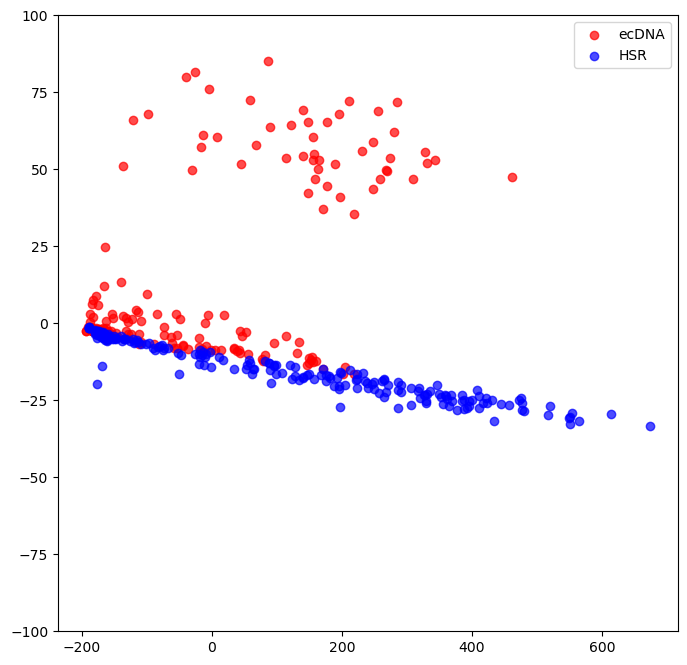

In [119]:
ec_mask = (G.y == 1).cpu()

plt.figure(figsize=(8,8))
plt.scatter(pca_embeds[:, 0][ec_mask], pca_embeds[:, 1][ec_mask], color='red', label='ecDNA', alpha=0.7)
plt.scatter(pca_embeds[:, 0][~ec_mask], pca_embeds[:, 1][~ec_mask], color='blue', label='HSR', alpha=0.7)
plt.ylim(-100, 100)
plt.legend()
plt.savefig('sage_embeddings.png')
plt.show()

In [104]:
#test_acc_runs = []
test_acc_runs.append(test_accs)

In [105]:
#loss_runs = []
loss_runs.append(losses)

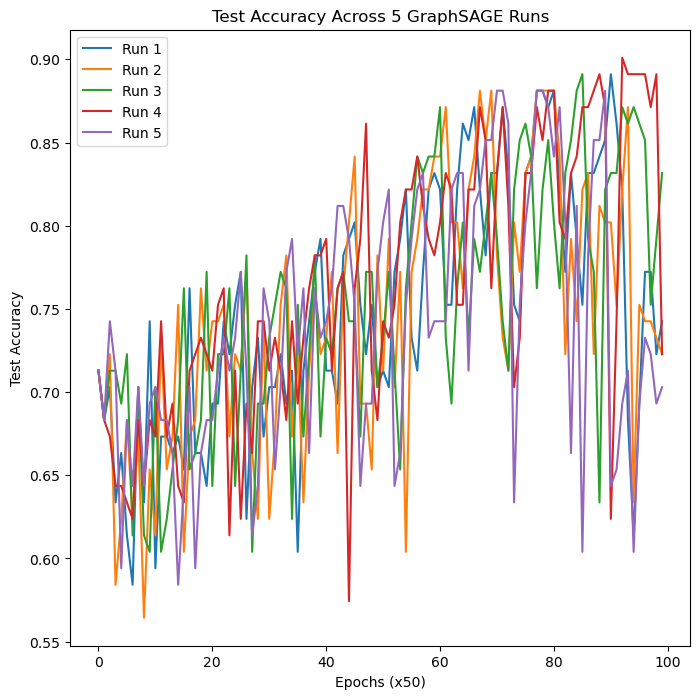

In [106]:
plt.figure(figsize=(8, 8))
for i, row in enumerate(test_acc_runs):
    plt.plot(row, label=f"Run {i+1}")

plt.xlabel("Epochs (x50)")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Across 5 GraphSAGE Runs")
plt.legend()
plt.savefig('sage_acc.png')
plt.show()

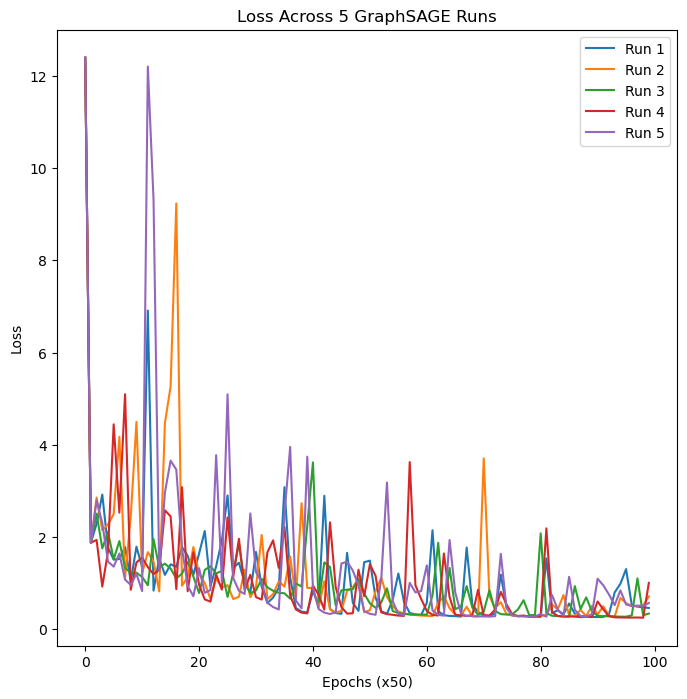

In [107]:
plt.figure(figsize=(8, 8))
for i, row in enumerate(loss_runs):
    plt.plot(row, label=f"Run {i+1}")

plt.xlabel("Epochs (x50)")
plt.ylabel("Loss")
plt.title("Loss Across 5 GraphSAGE Runs")
plt.legend()
plt.savefig('sage_loss.png')
plt.show()